Parsed sample rate: 2.400 MS/s
Loaded 178123189 complex samples
Total duration: 74.22 seconds
[START DETECT] First stable transition at index 49, time 2.450 s, energy 3.742258058991865e-07

Decoded messages:
Hello
Saved CSV: decoded_bits_dynamic_median.csv
Saved TXT: decoded_bits_dynamic_median.txt

Decoded bits (first 200):
 1010101001001000011001010110110001101100011011110010000101010101000011


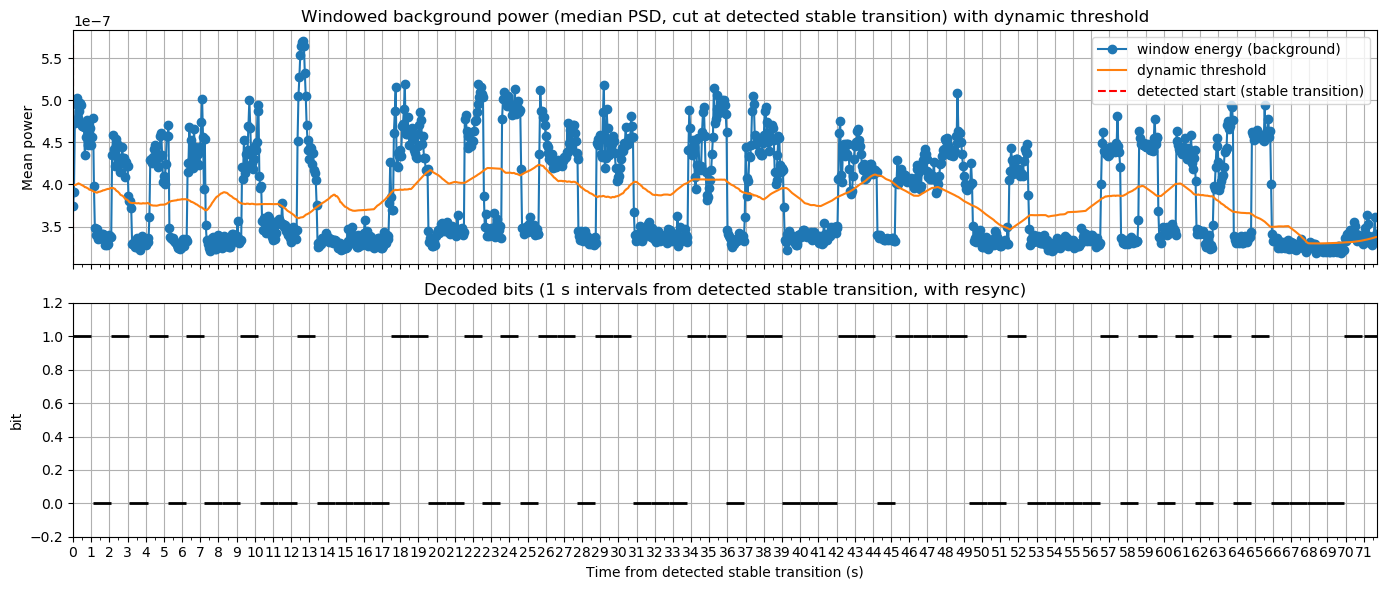

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib.ticker import MultipleLocator
from scipy.signal import welch  # Для PSD

def two_cluster_threshold(vals, max_iters=100, tol=1e-6):
    vals = vals.astype(float)
    c1, c2 = vals.min(), vals.max()
    for _ in range(max_iters):
        d1 = np.abs(vals - c1)
        d2 = np.abs(vals - c2)
        mask = d1 <= d2
        new_c1 = vals[mask].mean() if mask.any() else c1
        new_c2 = vals[~mask].mean() if (~mask).any() else c2
        if abs(new_c1 - c1) < tol and abs(new_c2 - c2) < tol:
            break
        c1, c2 = new_c1, new_c2
    return (c1 + c2) / 2.0, (c1, c2)

def sliding_mean_threshold(times,
                           energies,
                           look_back_sec=2.5,
                           look_ahead_sec=2.5):
    thresholds = np.empty_like(energies, dtype=float)
    for i, t in enumerate(times):
        start = t - look_back_sec
        end = t + look_ahead_sec
        mask = (times >= start) & (times < end)
        window = energies[mask]
        if window.size:
            thresholds[i] = window.mean()
        else:
            thresholds[i] = energies[i]
    return thresholds

def _compute_energies_and_times(iq_data, sample_rate, window_sec,
                                welch_nperseg=4096):
    total_samples = len(iq_data)
    w_s = int(max(1, round(window_sec * sample_rate)))
    n_windows = total_samples // w_s
    if n_windows == 0:
        raise ValueError("Слишком короткий файл для заданного window_sec")

    energies = np.empty(n_windows, dtype=np.float64)
    for i in range(n_windows):
        start_s = i * w_s
        end_s = start_s + w_s
        chunk = iq_data[start_s:end_s]
        
        f, Pxx = welch(chunk, fs=sample_rate, nperseg=welch_nperseg, return_onesided=False)
        f = np.fft.fftshift(f)
        Pxx = np.fft.fftshift(Pxx)
        
        if len(Pxx) > 0:
            energies[i] = np.median(Pxx) * len(Pxx)
        else:
            energies[i] = 0.0

    times = np.arange(n_windows, dtype=float) * window_sec
    return energies, times, w_s

def detect_first_stable_transition(energies, times, window_sec, bit_sec=1.0, look_back_windows=50):
    """
    Улучшенный метод: бинаризация с sliding two_cluster + run-length check.
    Sliding: Для каждого потенциального idx используем threshold на последних look_back_windows.
    """
    windows_per_bit = max(1, int(round(bit_sec / window_sec)))
    diffs = []  # Соберём кандидаты позже

    # Для бинаризации используем sliding window
    bits_raw = np.zeros(len(energies), dtype=int)
    for i in range(len(energies)):
        start_win = max(0, i - look_back_windows + 1)
        window_energies = energies[start_win:i+1]
        if len(window_energies) < 2:
            threshold = np.median(window_energies) if len(window_energies) else 0
        else:
            threshold, _ = two_cluster_threshold(window_energies)
        bits_raw[i] = 1 if energies[i] >= threshold else 0

    # Теперь diffs на bits_raw
    diffs = np.where(np.diff(bits_raw) != 0)[0] + 1
    chosen = None
    for idx in diffs:
        j = idx
        while j < len(bits_raw) and bits_raw[j] == bits_raw[idx]:
            j += 1
        run_right = j - idx
        i = idx - 1
        while i >= 0 and bits_raw[i] == bits_raw[idx-1]:
            i -= 1
        run_left = (idx - 1) - i
        if run_right >= windows_per_bit or (run_right >= max(1, windows_per_bit//2) and run_left >= max(1, windows_per_bit//2)):
            chosen = idx
            break
    if chosen is None and diffs.size > 0:
        chosen = diffs[0]
    if chosen is not None:
        return chosen, energies[chosen], times[chosen]
    return None, None, None

def decode_bits_to_message(decoded_bits):
    """
    Пост-обработка: находим start sequence, собираем байты до end sequence, декодируем в текст.
    Start: [1,0,1,0,1,0,1,0] (0xAA MSB first)
    End: [0,1,0,1,0,1,0,1] (0x55)
    Если несколько сообщений, декодируем все.
    Если битовая последовательность не кратна 8, декодируем столько полных байтов, сколько возможно.
    """
    start_seq = [1, 0, 1, 0, 1, 0, 1, 0]
    end_seq = [0, 1, 0, 1, 0, 1, 0, 1]
    seq_len = len(start_seq)
    
    messages = []
    i = 0
    while i <= len(decoded_bits) - seq_len:
        if list(decoded_bits[i:i+seq_len]) == start_seq:
            # Found start, collect bits until end
            j = i + seq_len
            bit_buffer = []
            while j <= len(decoded_bits) - seq_len:
                if list(decoded_bits[j:j+seq_len]) == end_seq:
                    # Decode as many full bytes as possible
                    num_bits = len(bit_buffer)
                    num_bytes = num_bits // 8
                    text = ''
                    for k in range(0, num_bytes * 8, 8):
                        byte_bits = bit_buffer[k:k+8]
                        byte_val = int(''.join(map(str, byte_bits)), 2)
                        text += chr(byte_val)
                    if text:
                        messages.append(text)
                    if num_bits % 8 != 0:
                        print(f"Warning: {num_bits % 8} remainder bits ignored in message decoding.")
                    i = j + seq_len - 1  # Move past end
                    break
                else:
                    bit_buffer.append(decoded_bits[j])
                    j += 1
            else:
                # No end found, skip
                pass
        i += 1
    
    return messages

def decode_energy_bits_dynamic(path,
                               window_sec=0.2,
                               look_back_sec=3.0,
                               look_ahead_sec=1.0,
                               bit_sec=1.0,
                               min_bit_consensus=0.5,
                               welch_nperseg=4096,
                               look_back_windows=50,  # Для sliding cluster
                               shift_step=0.5,  # Шаг сдвига окна при low confidence (в сек)
                               confidence_threshold=0.7,  # Min confidence для high (abs(val_fraction - 0.5)*2)
                               save_prefix="decoded_bits_dynamic_median"):
    base = os.path.basename(path)
    parts = base.split('_')
    sample_rate = int(parts[4])
    print(f"Parsed sample rate: {sample_rate / 1e6:.3f} MS/s")

    iq_data = np.memmap(path, dtype=np.complex64, mode='r')
    total_samples = len(iq_data)
    total_duration = total_samples / sample_rate
    print(f"Loaded {total_samples} complex samples")
    print(f"Total duration: {total_duration:.2f} seconds")

    energies_full, times_full, w_s = _compute_energies_and_times(
        iq_data, sample_rate, window_sec,
        welch_nperseg=welch_nperseg
    )

    start_idx, start_energy, start_time = detect_first_stable_transition(energies_full, times_full, window_sec, bit_sec, look_back_windows)
    if start_idx is None:
        print("[START DETECT] Stable transition not found, starting from 0")
        start_idx = 0
        start_energy = energies_full[0]
        start_time = times_full[0]
    else:
        print(f"[START DETECT] First stable transition at index {start_idx}, time {start_time:.3f} s, energy {start_energy}")

    energies = energies_full[start_idx:].copy()
    times_shifted = times_full[start_idx:] - start_time

    dyn_threshold = sliding_mean_threshold(
        times_shifted, energies,
        look_back_sec=look_back_sec,
        look_ahead_sec=look_ahead_sec
    )
    dyn_bits = (energies >= dyn_threshold).astype(int)

    end_time = float(times_shifted[-1] + window_sec if len(times_shifted) > 0 else 0)
    n_bits = max(0, int(np.ceil(end_time / bit_sec)))  # ceil для покрытия остатка

    decoded_bits = []
    decoded_times = []
    decoded_energies = []
    current_offset = 0.0  # Аккумулированный сдвиг для resync

    for b_idx in range(n_bits):
        t0 = b_idx * bit_sec + current_offset
        t1 = t0 + bit_sec
        mask = (times_shifted >= t0) & (times_shifted < t1)
        if not mask.any():
            continue

        slice_bits = dyn_bits[mask]
        slice_energies = energies[mask]

        val_fraction = slice_bits.mean()
        confidence = abs(val_fraction - 0.5) * 2  # 1.0 если 0 или 1, 0 если 0.5

        # Если low confidence, пробуем сдвиг и выбираем лучший
        if confidence < confidence_threshold:
            best_fraction = val_fraction
            best_bit = 1 if val_fraction >= min_bit_consensus else 0
            best_offset = 0.0
            for offset in [-shift_step, shift_step]:
                t0_shift = t0 + offset
                t1_shift = t1 + offset
                mask_shift = (times_shifted >= t0_shift) & (times_shifted < t1_shift)
                if mask_shift.any():
                    slice_bits_shift = dyn_bits[mask_shift]
                    fraction_shift = slice_bits_shift.mean()
                    if abs(fraction_shift - 0.5) > abs(best_fraction - 0.5):
                        best_fraction = fraction_shift
                        best_bit = 1 if fraction_shift >= min_bit_consensus else 0
                        best_offset = offset
            current_offset += best_offset  # Аккумулируем сдвиг для будущих окон
            val_fraction = best_fraction
            t0 += best_offset  # Корректируем t0 для этого бита

        bit = 1 if val_fraction >= min_bit_consensus else 0

        decoded_bits.append(bit)
        decoded_times.append(t0)
        decoded_energies.append(slice_energies.mean() if not mask.any() else np.mean(energies[mask_shift] if 'mask_shift' in locals() else slice_energies))

    decoded_bits = np.array(decoded_bits, dtype=int)
    decoded_times = np.array(decoded_times, dtype=float)
    decoded_energies = np.array(decoded_energies, dtype=float)

    # --- Пост-обработка: декодирование в сообщение ---
    messages = decode_bits_to_message(decoded_bits)
    print("\nDecoded messages:")
    for msg in messages:
        print(msg)

    df = pd.DataFrame({
        "time_start_s": decoded_times,
        "energy_mean": decoded_energies,
        "bit": decoded_bits,
    })
    csv_path = f"{save_prefix}.csv"
    txt_path = f"{save_prefix}.txt"

    df.to_csv(csv_path, index=False)
    with open(txt_path, "w") as f:
        f.write("".join(str(b) for b in decoded_bits))

    print("Saved CSV:", csv_path)
    print("Saved TXT:", txt_path)
    print("\nDecoded bits (first 200):\n", "".join(str(b) for b in decoded_bits[:200]))

    if len(times_shifted) > 0:
        common_xlim = (0.0, float(times_shifted[-1]))
    else:
        common_xlim = (0.0, 0.0)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    ax1.set_title("Windowed background power (median PSD, cut at detected stable transition) with dynamic threshold")
    ax1.plot(times_shifted, energies, "-o", label="window energy (background)")
    ax1.plot(times_shifted, dyn_threshold, label="dynamic threshold")
    ax1.axvline(0.0, color="red", linestyle="--", label="detected start (stable transition)")
    ax1.set_ylabel("Mean power")
    ax1.grid(True)
    ax1.legend()
    ax1.xaxis.set_major_locator(MultipleLocator(1.0))
    ax1.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax1.set_xlim(*common_xlim)

    ax2.set_title("Decoded bits (1 s intervals from detected stable transition, with resync)")
    if len(decoded_times) > 0:
        for t0, bit in zip(decoded_times, decoded_bits):
            t1 = t0 + bit_sec
            ax2.hlines(bit, t0, t1, linewidth=2)
    ax2.set_ylim(-0.2, 1.2)
    ax2.set_xlabel("Time from detected stable transition (s)")
    ax2.set_ylabel("bit")
    ax2.grid(True)
    ax2.xaxis.set_major_locator(MultipleLocator(1.0))
    ax2.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax2.set_xlim(*common_xlim)

    fig.tight_layout()
    plt.show()

    return {
        "sample_rate": sample_rate,
        "window_sec": window_sec,
        "bit_sec": bit_sec,
        "look_back_sec": look_back_sec,
        "look_ahead_sec": look_ahead_sec,
        "energies_cut": energies,
        "times_cut": times_shifted,
        "dyn_threshold": dyn_threshold,
        "dyn_bits": dyn_bits,
        "start_index_full": start_idx,
        "start_time_full_s": start_time,
        "start_energy_full": start_energy,
        "decoded_bits": decoded_bits,
        "decoded_times": decoded_times,
        "decoded_energies": decoded_energies,
        "decoded_messages": messages,
        "csv": csv_path,
        "txt": txt_path,
    }

res = decode_energy_bits_dynamic(
    "gqrx_20251212_203858_2380000000_2400000_fc.raw",
    window_sec=0.05,
    look_back_sec=2.0,
    look_ahead_sec=5.0,
    bit_sec=1.0,
    min_bit_consensus=0.5,
    welch_nperseg=8192,
    look_back_windows=50,
    shift_step=0.1,
    confidence_threshold=0.8,
    save_prefix="decoded_bits_dynamic_median"
)

Parsed sample rate: 2.400 MS/s
Parsed center frequency: 2.380 GHz
Loaded 305917249 complex samples
Total duration: 127.47 seconds
[START DETECT] First stable transition at index 22, time 0.550 s, energy 1.5539768583039404e-08

Decoded messages:
Hello guys today we gonna lern how to hack your PC haha 

Saved CSV: decoded_bits_dynamic_median.csv
Saved TXT: decoded_bits_dynamic_median.txt

Decoded bits (first 200):
 00000000000101010100100100001100101011011000110110001101111001000000110011101110101011110010111001100100000011101000110111101100100011000010111100100100000011101110110010100100000011001110110111101101


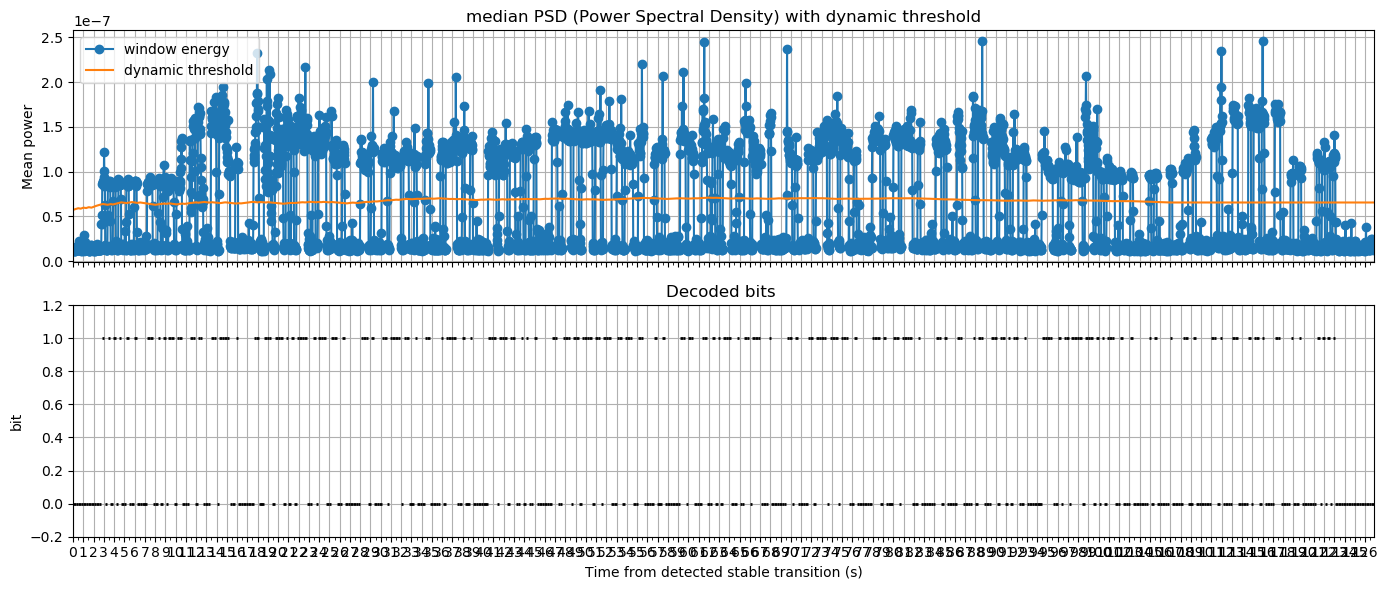

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib.ticker import MultipleLocator
from scipy.signal import welch 

# Функция для вычисления порога на основе двух кластеров (k-means-подобный алгоритм)
# Возвращает порог (среднее центров) и центры кластеров
def two_cluster_threshold(vals, max_iters=100, tol=1e-6):
    vals = vals.astype(float) 
    c1, c2 = vals.min(), vals.max()  # Инициализация центров как мин/макс
    for _ in range(max_iters):  # Итеративный поиск центров
        d1 = np.abs(vals - c1)  # Расстояния до c1
        d2 = np.abs(vals - c2)  # Расстояния до c2
        mask = d1 <= d2  # Маска для кластера 1
        new_c1 = vals[mask].mean() if mask.any() else c1  # Новый центр 1
        new_c2 = vals[~mask].mean() if (~mask).any() else c2  # Новый центр 2
        if abs(new_c1 - c1) < tol and abs(new_c2 - c2) < tol:  # Проверка сходимости
            break
        c1, c2 = new_c1, new_c2  # Обновление центров
    return (c1 + c2) / 2.0, (c1, c2)  

# Функция для вычисления скользящего среднего порога
# Возвращает массив порогов для каждого времени
def sliding_mean_threshold(times,
                           energies,
                           look_back_sec=2.5,
                           look_ahead_sec=2.5):
    thresholds = np.empty_like(energies, dtype=float) 
    for i, t in enumerate(times):  
        start = min(t - look_back_sec, 0)  
        end = t + look_ahead_sec 
        mask = (times >= start) & (times < end)  
        window = energies[mask] 
        if window.size:  
            thresholds[i] = window.mean() 
        else:
            thresholds[i] = energies[i]  
    return thresholds

# Вычисление энергий и времен в окнах
# Возвращает энергии, времена
def _compute_energies_and_times(iq_data, sample_rate, window_sec,
                                welch_nperseg=4096):
    total_samples = len(iq_data)  # Общее число семплов
    w_s = int(max(1, round(window_sec * sample_rate)))  # Размер окна в семплах
    n_windows = total_samples // w_s  # Число окон
    
    if n_windows == 0:
        raise ValueError("Слишком короткий файл для заданного window_sec")

    energies = np.empty(n_windows, dtype=np.float64) 
    for i in range(n_windows): 
        start_s = i * w_s  
        end_s = start_s + w_s  
        chunk = iq_data[start_s:end_s]  
        
        # Вычисление PSD (Power Spectral Density) - ака преобразование Фурье, но разделяет чанк на welch_nperseg частей и усредняет по ним
        f, Pxx = welch(chunk, fs=sample_rate, nperseg=welch_nperseg, return_onesided=False)
        
        if len(Pxx) > 0: 
            energies[i] = np.median(Pxx) * len(Pxx)  
        else:
            energies[i] = 0.0 

    times = np.arange(n_windows, dtype=float) * window_sec
    return energies, times

# Функция для детекции первого стабильного перехода бита
# Возвращает индекс, энергию и время старта
def detect_first_stable_transition(energies, times, window_sec, bit_sec, look_back_windows):
    windows_per_bit = max(1, int(round(bit_sec / window_sec)))
    diffs = []

    bits_raw = np.zeros(len(energies), dtype=int)  # Массив сырых предположительно битов (на окно)
    for i in range(len(energies)): 
        start_win = max(0, i - look_back_windows + 1) 
        window_energies = energies[start_win:i+1]
        if len(window_energies) < 2: 
            threshold = np.median(window_energies) if len(window_energies) else 0
        else:
            threshold, _ = two_cluster_threshold(window_energies) 
        bits_raw[i] = 1 if energies[i] >= threshold else 0

    diffs = np.where(np.diff(bits_raw) != 0)[0] + 1  # Индексы переходов
    chosen = None
    for idx in diffs:
        j = idx
        while j < len(bits_raw) and bits_raw[j] == bits_raw[idx]:
            j += 1
        run_right = j - idx
        i = idx - 1
        while i >= 0 and bits_raw[i] == bits_raw[idx-1]:
            i -= 1
        run_left = (idx - 1) - i
        if run_right >= windows_per_bit - 1  or (run_right >= max(1, windows_per_bit//2) and run_left >= max(1, windows_per_bit//2)):  # Проверка стабильности
            chosen = idx  # Выбор первого стабильного
            break
    if chosen is None and diffs.size > 0: 
        chosen = diffs[0]
    if chosen is not None: 
        return chosen, energies[chosen], times[chosen]
    return None, None, None 

# Функция для декодирования битов в сообщение
# Возвращает список сообщений
def decode_bits_to_message(decoded_bits):
    start_seq = [1, 0, 1, 0, 1, 0, 1, 0] 
    end_seq = [0, 1, 0, 1, 0, 1, 0, 1] 
    seq_len = len(start_seq) 
    
    messages = []  
    i = 0  
    while i <= len(decoded_bits) - seq_len: 
        if list(decoded_bits[i:i+seq_len]) == start_seq: # Найден start
            j = i + seq_len  # Начало данных
            
            bit_buffer = [] 
            
            while j <= len(decoded_bits) - seq_len:
                if list(decoded_bits[j:j+seq_len]) == end_seq:  # Найден end
                    num_bits = len(bit_buffer)  
                    num_bytes = num_bits // 8 
                    
                    text = '' 
                    for k in range(0, num_bytes * 8, 8): 
                        byte_bits = bit_buffer[k:k+8]  
                        byte_val = int(''.join(map(str, byte_bits)), 2) 
                        text += chr(byte_val)  
                    if text:  
                        messages.append(text) 
                    if num_bits % 8 != 0:
                        print(f"Warning: {num_bits % 8} remainder bits ignored in message decoding.")
                    i = j + seq_len - 1 
                    break
                else:
                    bit_buffer.append(decoded_bits[j]) 
                    j += 1
            else:
                pass
        i += 1 
    
    return messages

# Основная функция декодирования
# path: путь к файлу
# window_sec: длительность окна
# look_back_sec: назад для порога
# look_ahead_sec: вперед для порога
# bit_sec: длительность бита
# min_bit_consensus: минимальная доля для 1
# welch_nperseg: сегментов для welch
# look_back_windows: окон для clustering
# shift_step: шаг сдвига для resync
# confidence_threshold: порог уверенности
# save_prefix: префикс для сохранения
# sample_rate: опциональный sample_rate (если не найдено из названия файла)
# center_freq: опциональная center frequency (если не найдено из названия файла)
# Возвращает словарь с результатами
def decode_energy_bits_dynamic(path,
                               window_sec=0.2,
                               look_back_sec=3.0,
                               look_ahead_sec=1.0,
                               bit_sec=1.0,
                               min_bit_consensus=0.5,
                               welch_nperseg=8192,
                               look_back_windows=50,
                               shift_step=0.5,
                               confidence_threshold=0.7,
                               save_prefix="decoded_bits_dynamic_median",
                               sample_rate=None,
                               center_freq=None):
    try:
        base = os.path.basename(path) 
        parts = base.split('_') 
        parsed_sample_rate = int(parts[4])  
        parsed_center_freq = int(parts[3]) 
    except (IndexError, ValueError):  
        parsed_sample_rate = None
        parsed_center_freq = None

    if parsed_sample_rate is not None:
        sample_rate = parsed_sample_rate
    elif sample_rate is not None:
        pass
    else:
        raise ValueError("Sample rate not found in filename and not provided as argument")

    if parsed_center_freq is not None:
        center_freq = parsed_center_freq
    elif center_freq is not None:
        # Используем переданный
        pass
    else:
        raise ValueError("Center frequency not found in filename and not provided as argument")

    print(f"Parsed sample rate: {sample_rate / 1e6:.3f} MS/s")
    print(f"Parsed center frequency: {center_freq / 1e9:.3f} GHz")

    iq_data = np.memmap(path, dtype=np.complex64, mode='r')  # Memmap для больших файлов
    total_samples = len(iq_data) 
    total_duration = total_samples / sample_rate  
    print(f"Loaded {total_samples} complex samples")
    print(f"Total duration: {total_duration:.2f} seconds")

    energies_full, times_full = _compute_energies_and_times(
        iq_data, sample_rate, window_sec,
        welch_nperseg=welch_nperseg
    )

    start_idx, start_energy, start_time = detect_first_stable_transition(energies_full, times_full, window_sec, bit_sec, look_back_windows)
    if start_idx is None:
        print("[START DETECT] Stable transition not found, starting from 0")
        start_idx = 0
        start_energy = energies_full[0]
        start_time = times_full[0]
    else:
        print(f"[START DETECT] First stable transition at index {start_idx}, time {start_time:.3f} s, energy {start_energy}")

    energies = energies_full[start_idx:].copy() 
    times_shifted = times_full[start_idx:] - start_time  

    dyn_threshold = sliding_mean_threshold(
        times_shifted, energies,
        look_back_sec=look_back_sec,
        look_ahead_sec=look_ahead_sec
    )
    dyn_bits = (energies >= dyn_threshold).astype(int)  # Бинаризация по окнам

    end_time = float(times_shifted[-1] + window_sec if len(times_shifted) > 0 else 0)  
    n_bits = max(0, int(np.ceil(end_time / bit_sec)))  

    decoded_bits = []  
    decoded_times = []  
    decoded_energies = []  
    current_offset = 0.0  

    for b_idx in range(n_bits):
        t0 = b_idx * bit_sec + current_offset  # Начало интервала
        t1 = t0 + bit_sec  # Конец
        mask = (times_shifted >= t0) & (times_shifted < t1) 
        if not mask.any(): 
            continue

        slice_bits = dyn_bits[mask]  
        slice_energies = energies[mask]  

        val_fraction = slice_bits.mean() 
        confidence = abs(val_fraction - 0.5) * 2 

        # Если низкая confidence, пробуем сдвиг
        if confidence < confidence_threshold:
            best_fraction = val_fraction
            best_offset = 0.0
            for offset in [-shift_step, shift_step]:  
                t0_shift = t0 + offset
                t1_shift = t1 + offset
                mask_shift = (times_shifted >= t0_shift) & (times_shifted < t1_shift)
                if mask_shift.any():
                    slice_bits_shift = dyn_bits[mask_shift]
                    fraction_shift = slice_bits_shift.mean()
                    if abs(fraction_shift - 0.5) > abs(best_fraction - 0.5): 
                        best_fraction = fraction_shift
                        best_offset = offset
            current_offset += best_offset  # Обновление offset
            val_fraction = best_fraction
            t0 += best_offset  # Коррекция t0

        bit = 1 if val_fraction >= min_bit_consensus else 0 

        decoded_bits.append(bit) 
        decoded_times.append(t0)
        decoded_energies.append(slice_energies.mean() if slice_energies.size > 0 else 0.0)

    decoded_bits = np.array(decoded_bits, dtype=int)
    decoded_times = np.array(decoded_times, dtype=float)
    decoded_energies = np.array(decoded_energies, dtype=float)

    messages = decode_bits_to_message(decoded_bits)
    print("\nDecoded messages:")
    for msg in messages: 
        print(msg)
    print("")

    df = pd.DataFrame({
        "time_start_s": decoded_times,
        "energy_mean": decoded_energies,
        "bit": decoded_bits,
    })
    csv_path = f"{save_prefix}.csv"  
    txt_path = f"{save_prefix}.txt" 

    df.to_csv(csv_path, index=False) 
    with open(txt_path, "w") as f: 
        f.write("".join(str(b) for b in decoded_bits))

    print("Saved CSV:", csv_path)
    print("Saved TXT:", txt_path)
    print("\nDecoded bits (first 200):\n", "".join(str(b) for b in decoded_bits[:200]))

    if len(times_shifted) > 0: 
        common_xlim = (0.0, float(times_shifted[-1]))
    else:
        common_xlim = (0.0, 0.0)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True) 

    ax1.set_title("median PSD (Power Spectral Density) with dynamic threshold")  
    ax1.plot(times_shifted, energies, "-o", label="window energy")  
    ax1.plot(times_shifted, dyn_threshold, label="dynamic threshold")  
    ax1.set_ylabel("Mean power") 
    ax1.grid(True)  
    ax1.legend()  
    ax1.xaxis.set_major_locator(MultipleLocator(1.0)) 
    ax1.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax1.set_xlim(*common_xlim)  

    ax2.set_title("Decoded bits ")  
    if len(decoded_times) > 0:  
        for t0, bit in zip(decoded_times, decoded_bits):
            t1 = t0 + bit_sec
            ax2.hlines(bit, t0, t1, linewidth=2)
    ax2.set_ylim(-0.2, 1.2)  
    ax2.set_xlabel("Time from detected stable transition (s)") 
    ax2.set_ylabel("bit")  
    ax2.grid(True) 
    ax2.xaxis.set_major_locator(MultipleLocator(1.0))
    ax2.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax2.set_xlim(*common_xlim)

    fig.tight_layout()
    plt.show() 

    return {
        "sample_rate": sample_rate,
        "center_freq": center_freq,
        "window_sec": window_sec,
        "bit_sec": bit_sec,
        "look_back_sec": look_back_sec,
        "look_ahead_sec": look_ahead_sec,
        "energies_cut": energies,
        "times_cut": times_shifted,
        "dyn_threshold": dyn_threshold,
        "dyn_bits": dyn_bits,
        "start_index_full": start_idx,
        "start_time_full_s": start_time,
        "start_energy_full": start_energy,
        "decoded_bits": decoded_bits,
        "decoded_times": decoded_times,
        "decoded_energies": decoded_energies,
        "decoded_messages": messages,
        "csv": csv_path,
        "txt": txt_path,
    }

res = decode_energy_bits_dynamic(
    "HelloguystodaywegonnalernhowtohackyourPChaha_20251213_151756_2380000000_2400000_fc.raw",
    window_sec=0.025,
    look_back_sec=20.0,
    look_ahead_sec=20.0,
    bit_sec=0.25,
    min_bit_consensus=0.5,
    welch_nperseg=256,
    look_back_windows=50,
    shift_step=0.05,
    confidence_threshold=0.9,
    save_prefix="decoded_bits_dynamic_median",
    sample_rate=2400000,  
    center_freq=2380000000
)

Parsed sample rate: 2.400 MS/s
Parsed center frequency: 2.380 GHz
Loaded 157413669 complex samples
Total duration: 65.59 seconds
[START DETECT] First stable transition at index 62, time 3.100 s, energy 6.076238037167059e-07

Decoded messages:
Hello

Saved CSV: temp.csv
Saved TXT: temp.txt

Decoded bits (first 200):
 00101010100100100001100101011011000110110001101111010101010000


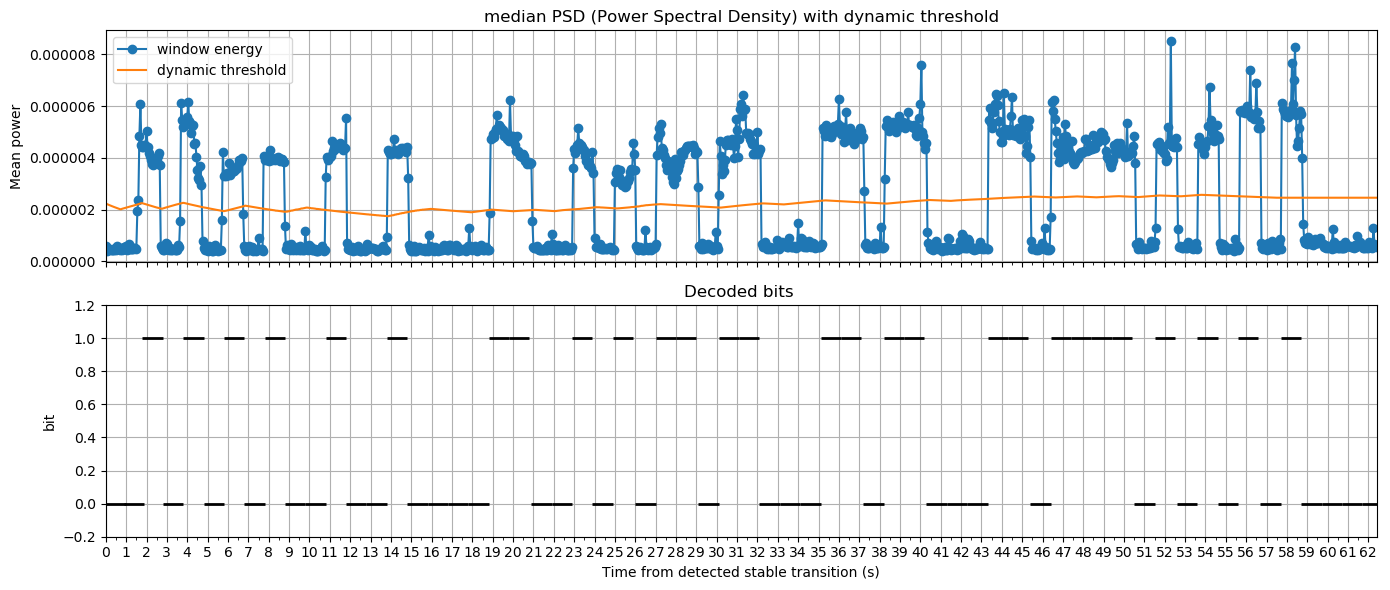

Parsed sample rate: 2.400 MS/s
Parsed center frequency: 2.380 GHz
Loaded 152038153 complex samples
Total duration: 63.35 seconds
[START DETECT] First stable transition at index 29, time 1.450 s, energy 4.995392828277545e-07

Decoded messages:
Hello

Saved CSV: temp.csv
Saved TXT: temp.txt

Decoded bits (first 200):
 00101010100100100001100101011011000110110001101111010101010000


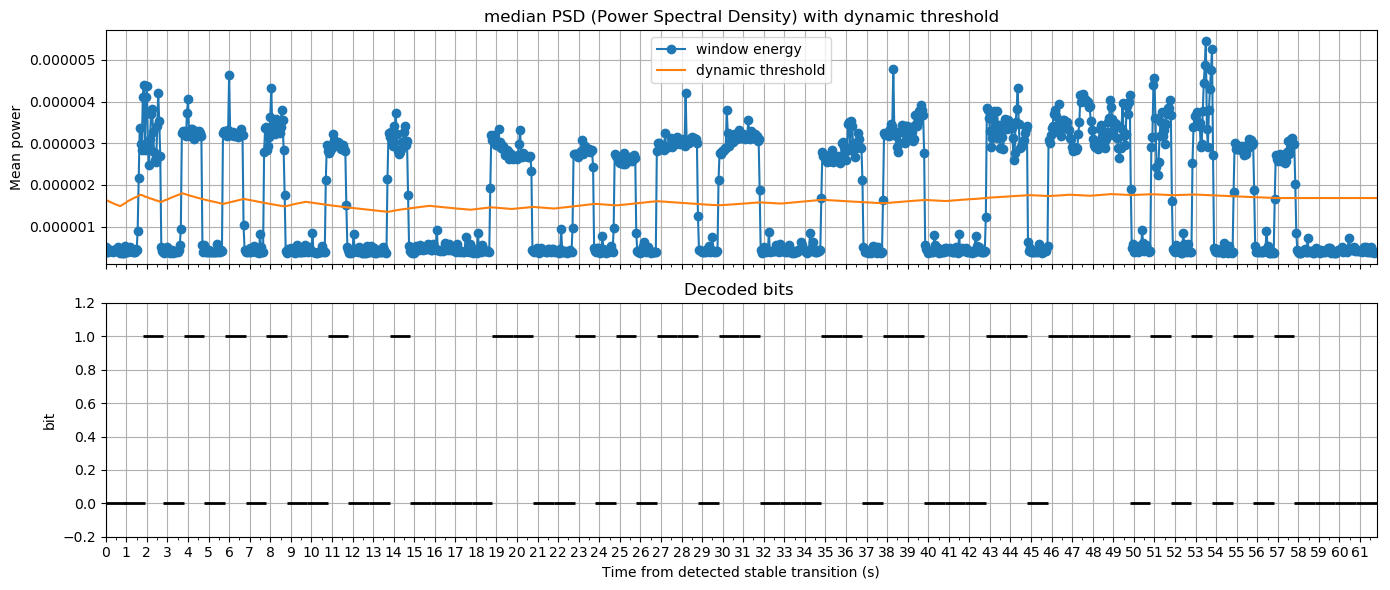

Parsed sample rate: 2.400 MS/s
Parsed center frequency: 2.380 GHz
Loaded 148367665 complex samples
Total duration: 61.82 seconds
[START DETECT] First stable transition at index 64, time 3.200 s, energy 1.5885059383435873e-06

Decoded messages:
Hello

Saved CSV: temp.csv
Saved TXT: temp.txt

Decoded bits (first 200):
 10101010010010000110010101101100011011000110111101010101000


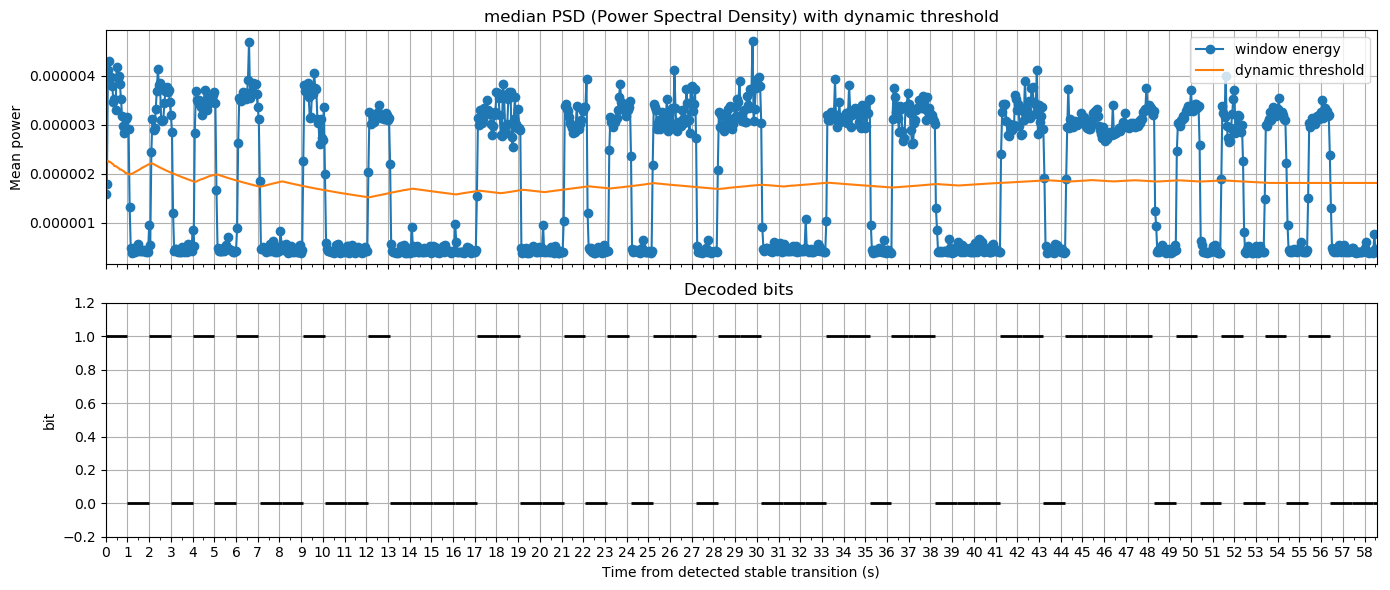

Parsed sample rate: 2.400 MS/s
Parsed center frequency: 2.380 GHz
Loaded 153349266 complex samples
Total duration: 63.90 seconds
[START DETECT] First stable transition at index 6, time 0.300 s, energy 3.754247472897987e-07

Decoded messages:
Hello

Saved CSV: temp.csv
Saved TXT: temp.txt

Decoded bits (first 200):
 001010101001001000011001010110110001101100011011110101010100000


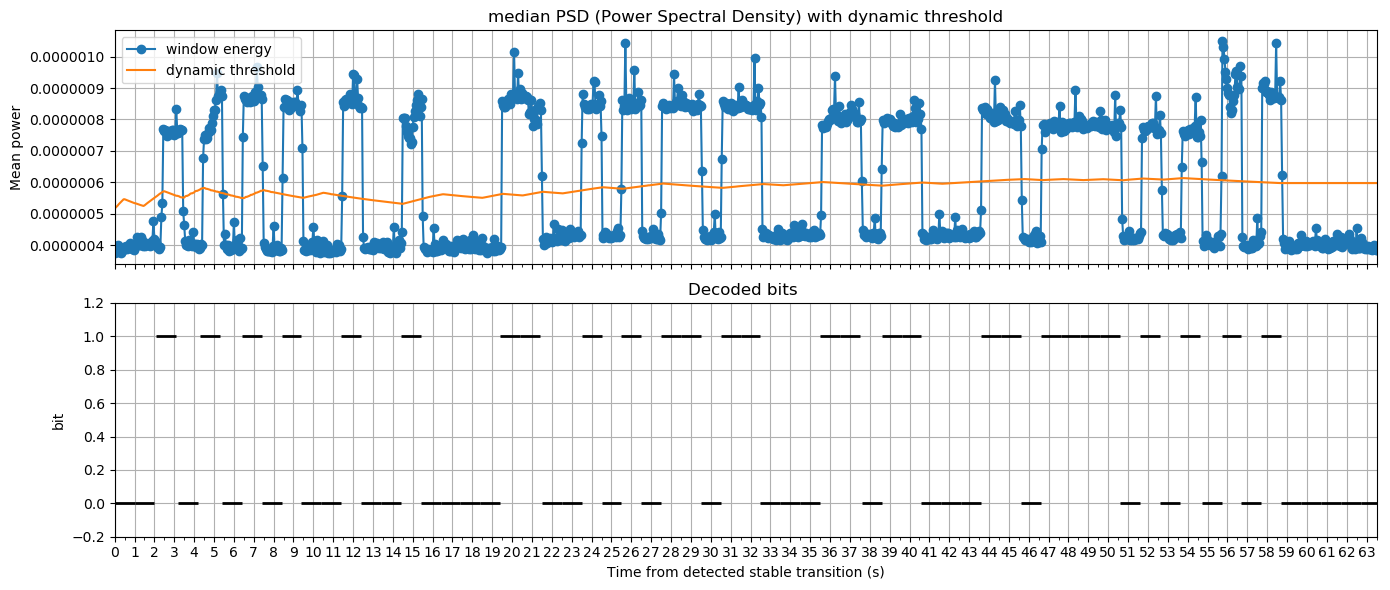

Parsed sample rate: 2.400 MS/s
Parsed center frequency: 2.380 GHz
Loaded 152302426 complex samples
Total duration: 63.46 seconds
[START DETECT] First stable transition at index 50, time 2.500 s, energy 4.106299229533761e-07

Decoded messages:
Hello

Saved CSV: temp.csv
Saved TXT: temp.txt

Decoded bits (first 200):
 1010101001001000011001010110110001101100011011110101010100000


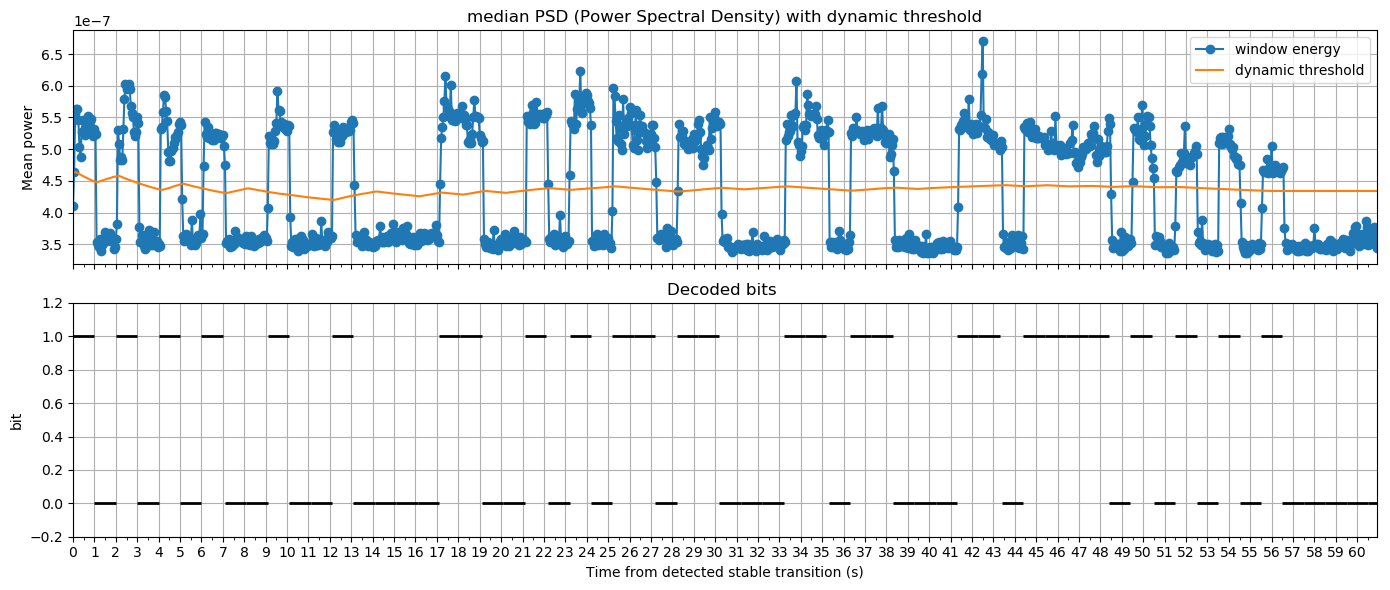

Parsed sample rate: 2.400 MS/s
Parsed center frequency: 2.380 GHz
Loaded 160952805 complex samples
Total duration: 67.06 seconds
[START DETECT] First stable transition at index 47, time 2.350 s, energy 3.976900586621923e-07

Decoded messages:
Hello

Saved CSV: temp.csv
Saved TXT: temp.txt

Decoded bits (first 200):
 10101010010010000110010101101100011011000110111101010101000000000


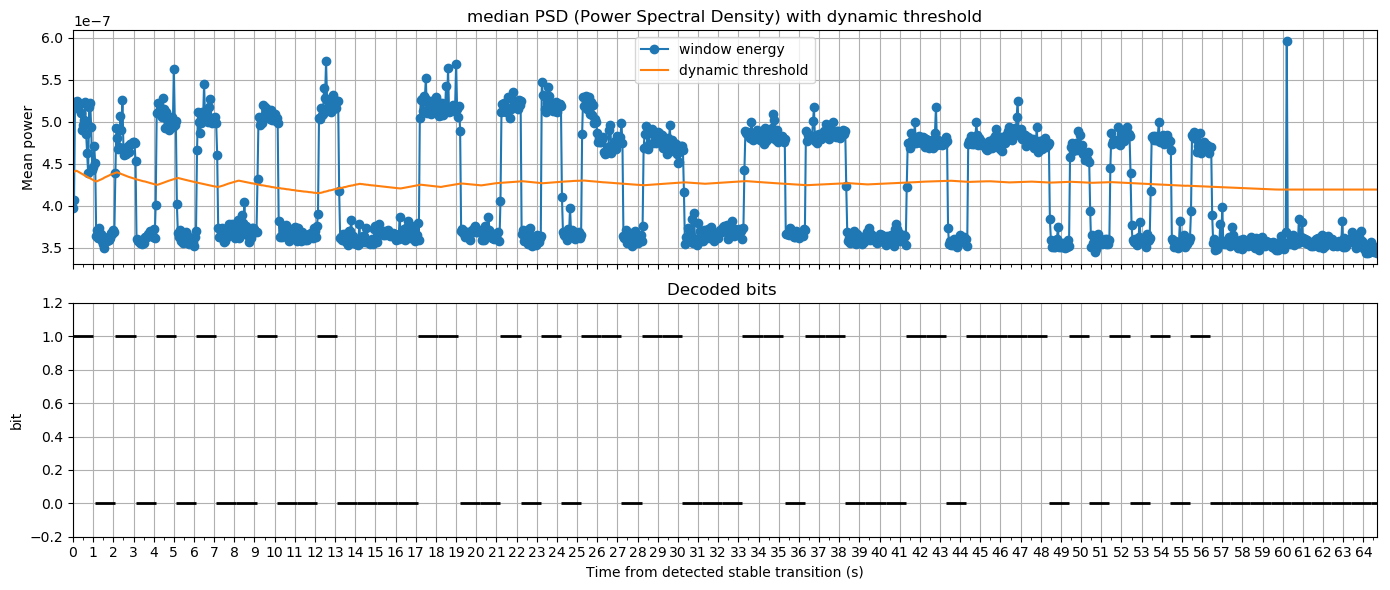

Parsed sample rate: 2.400 MS/s
Parsed center frequency: 2.380 GHz
Loaded 152561431 complex samples
Total duration: 63.57 seconds
[START DETECT] First stable transition at index 63, time 3.150 s, energy 3.900093190623011e-07

Decoded messages:
Hello

Saved CSV: temp.csv
Saved TXT: temp.txt

Decoded bits (first 200):
 101010100100100001100101011011000110110001101111010101010000


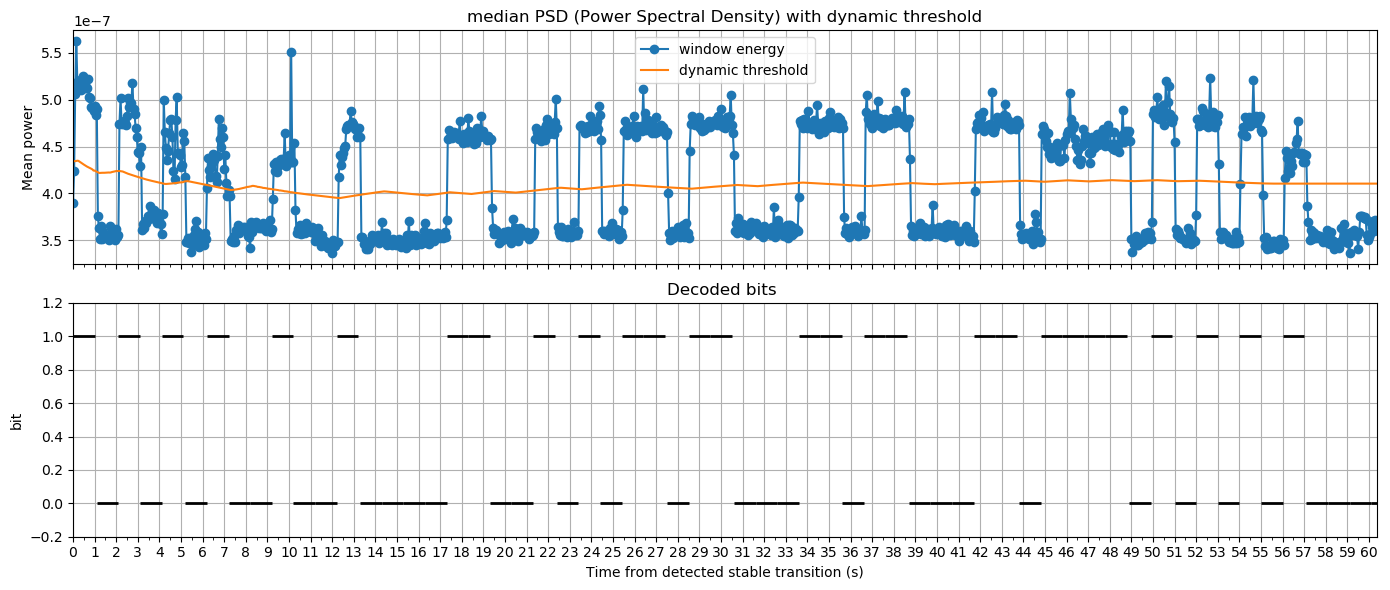

Parsed sample rate: 2.400 MS/s
Parsed center frequency: 2.380 GHz
Loaded 158854890 complex samples
Total duration: 66.19 seconds
[START DETECT] First stable transition at index 10, time 0.500 s, energy 4.0592746586298745e-07

Decoded messages:
Hello

Saved CSV: temp.csv
Saved TXT: temp.txt

Decoded bits (first 200):
 00011010101001001000011001010110110001101100011011110101010100001


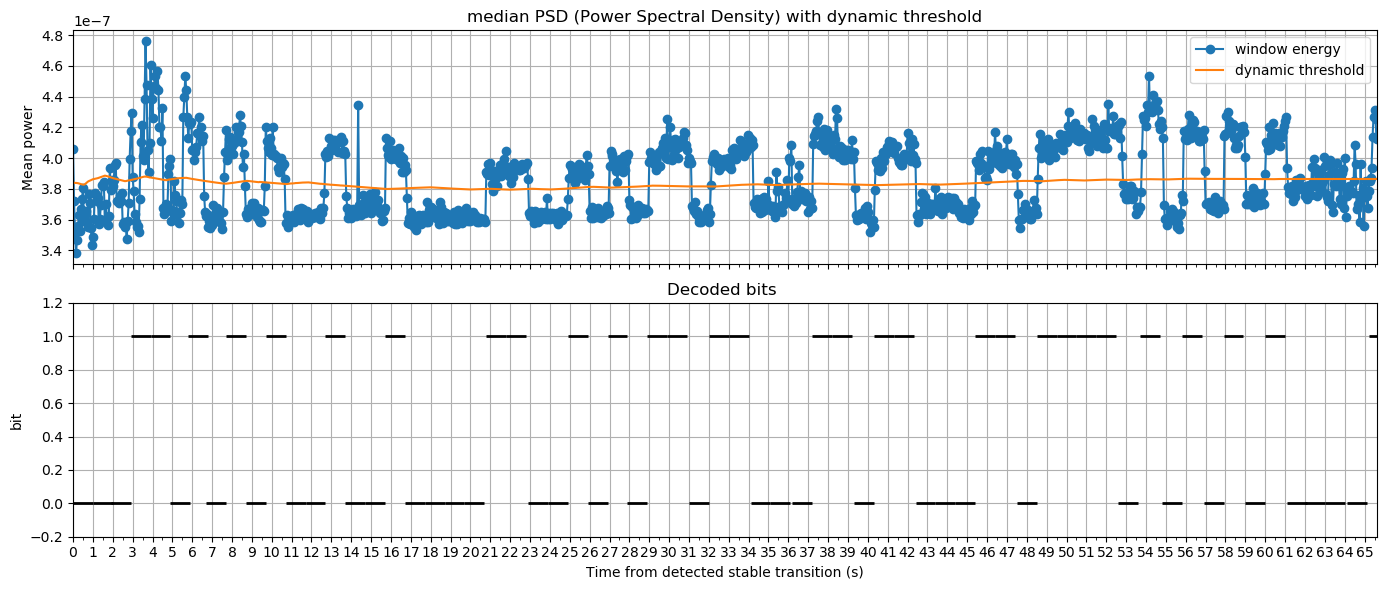

Distance: 30 cm (files: 183 energies), Delta: 7.18 dB, Error: 0.21
Distance: 100 cm (files: 63 energies), Delta: 2.64 dB, Error: 0.08
Distance: 200 cm (files: 126 energies), Delta: 1.37 dB, Error: 0.03
Distance: 350 cm (files: 60 energies), Delta: 1.03 dB, Error: 0.03
Distance: 500 cm (files: 65 energies), Delta: 0.36 dB, Error: 0.02


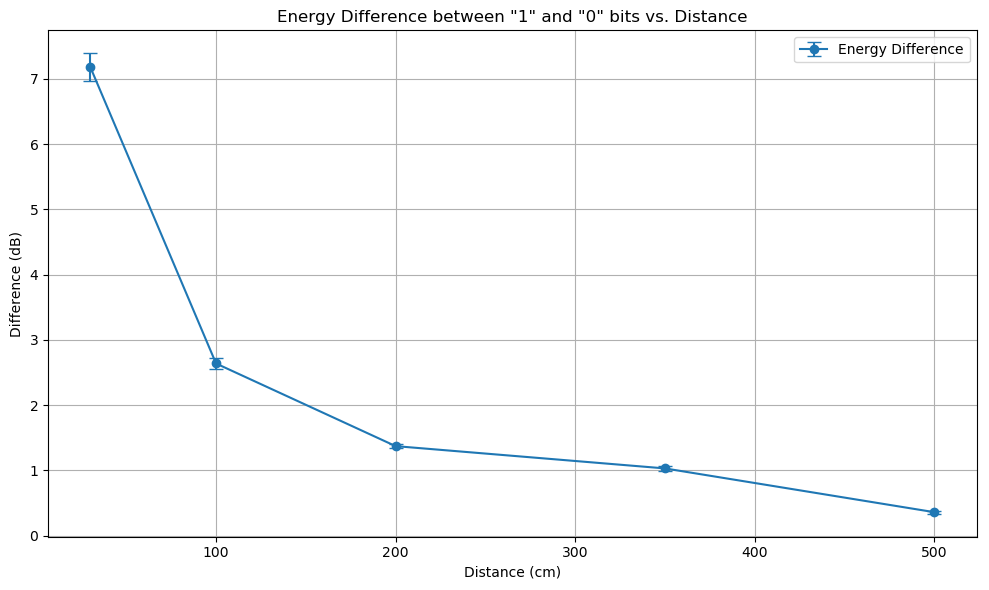

Plot saved as energy_diff_plot.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import pandas as pd
import os
from matplotlib.ticker import MultipleLocator

def plot_energy_diff_vs_distance(file_distance_pairs, window_sec=0.05, bit_sec=1.0, look_back_sec=2.0, look_ahead_sec=5.0,
                                 welch_nperseg=8192, look_back_windows=50, shift_step=0.1, confidence_threshold=0.8,
                                 min_bit_consensus=0.5, use_db=True, save_prefix="energy_diff_plot"):
    """
    Функция строит график разницы уровня энергии между битами '1' и '0' в зависимости от расстояния, с погрешностями.
    
    Параметры:
    - file_distance_pairs: list of tuples [(file_path1, distance_cm1), (file_path2, distance_cm2), ...]
    - use_db: Если True, разница в dB (10 * log10(mean_1 / mean_0)), иначе raw difference (mean_1 - mean_0)
    - Остальные параметры — для decode_energy_bits_dynamic
    
    Вычисляет для каждой уникальной дистанции (группируя файлы с одинаковой дистанцией):
    - Собирает все decoded_energies для '1' и '0' из всех файлов на этой дистанции
    - mean_1 = np.mean(all_energies_1), sem_1 = np.std(all_energies_1) / sqrt(len) (standard error of mean)
    - Аналогично для mean_0
    - delta = mean_1 - mean_0 (или в dB)
    - error = sqrt(sem_1^2 + sem_0^2) для raw; для dB — propagation of uncertainty: (10 / ln(10)) * sqrt( (sem_1/mean_1)^2 + (sem_0/mean_0)^2 )
    
    Строит график: x = distance (cm), y = delta, with errorbars = error
    Сортирует по расстоянию для графика.
    """
    from collections import defaultdict
    import math  # Для ln(10)
    
    # Группировка по дистанциям: dict[distance] = {'energies_1': [], 'energies_0': []}
    data_by_distance = defaultdict(lambda: {'energies_1': [], 'energies_0': []})
    
    for file_path, distance_cm in file_distance_pairs:
        # Парсим sample_rate и center_freq из имени файла или используем defaults/None
        try:
            base = os.path.basename(file_path)
            parts = base.split('_')
            sample_rate = int(parts[4]) if len(parts) > 4 else None
            center_freq = int(parts[3]) if len(parts) > 3 else None
        except:
            sample_rate = None
            center_freq = None
        
        # Вызываем декодер (игнорируем save_prefix, т.к. не сохраняем)
        res = decode_energy_bits_dynamic(
            file_path,
            window_sec=window_sec,
            look_back_sec=look_back_sec,
            look_ahead_sec=look_ahead_sec,
            bit_sec=bit_sec,
            min_bit_consensus=min_bit_consensus,
            welch_nperseg=welch_nperseg,
            look_back_windows=look_back_windows,
            shift_step=shift_step,
            confidence_threshold=confidence_threshold,
            save_prefix="temp",  # Временный, не сохраняем
            sample_rate=sample_rate,
            center_freq=center_freq
        )
        
        decoded_bits = res['decoded_bits']
        decoded_energies = res['decoded_energies']
        
        if len(decoded_bits) == 0:
            print(f"Warning: No bits decoded for {file_path}, skipping")
            continue
        
        # Маски для 0 и 1
        mask_1 = (decoded_bits == 1)
        mask_0 = (decoded_bits == 0)
        
        if not mask_1.any() or not mask_0.any():
            print(f"Warning: No '1' or '0' bits in {file_path}, skipping")
            continue
        
        # Добавляем энергии в группу
        data_by_distance[distance_cm]['energies_1'].extend(decoded_energies[mask_1])
        data_by_distance[distance_cm]['energies_0'].extend(decoded_energies[mask_0])
    
    if not data_by_distance:
        print("No valid data to plot")
        return
    
    distances = []
    deltas = []
    errors = []
    
    for distance_cm, data in data_by_distance.items():
        energies_1 = np.array(data['energies_1'])
        energies_0 = np.array(data['energies_0'])
        
        if len(energies_1) == 0 or len(energies_0) == 0:
            continue
        
        mean_1 = np.mean(energies_1)
        sem_1 = np.std(energies_1) / np.sqrt(len(energies_1)) if len(energies_1) > 1 else 0.0
        
        mean_0 = np.mean(energies_0)
        sem_0 = np.std(energies_0) / np.sqrt(len(energies_0)) if len(energies_0) > 1 else 0.0
        
        if use_db:
            if mean_0 == 0 or mean_1 <= 0:
                delta = np.nan  # Избежать ошибок
                error = np.nan
            else:
                delta = 10 * np.log10(mean_1 / mean_0)
                error = (10 / math.log(10)) * np.sqrt( (sem_1 / mean_1)**2 + (sem_0 / mean_0)**2 )
        else:
            delta = mean_1 - mean_0
            error = np.sqrt(sem_1**2 + sem_0**2)
        
        distances.append(distance_cm)
        deltas.append(delta)
        errors.append(error)
        print(f"Distance: {distance_cm} cm (files: {len(data['energies_1']) + len(data['energies_0'])} energies), Delta: {delta:.2f} {'dB' if use_db else 'raw'}, Error: {error:.2f}")
    
    # Сортировка по расстоянию
    sorted_idx = np.argsort(distances)
    distances = np.array(distances)[sorted_idx]
    deltas = np.array(deltas)[sorted_idx]
    errors = np.array(errors)[sorted_idx]
    
    # График с errorbars
    plt.figure(figsize=(10, 6))
    plt.errorbar(distances, deltas, yerr=errors, fmt='-o', capsize=5, label='Energy Difference')
    plt.xlabel('Distance (cm)')
    plt.ylabel('Difference (dB)' if use_db else 'Difference (raw energy units)')
    plt.title('Energy Difference between "1" and "0" bits vs. Distance')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{save_prefix}.png")
    plt.show()
    print(f"Plot saved as {save_prefix}.png")

pairs = [("2380MHz30cm_20251212_200000_2380000000_2400000_fc.raw", 30), 
         ("2380MHz30cm2_20251213_154643_2380000000_2400000_fc.raw", 30), 
         ("2380MHz30cm3_20251213_155113_2380000000_2400000_fc.raw", 30), 
         ("2380MHz100cm_20251213_161728_2380000000_2400000_fc.raw", 100),
         ("2380MHz200cm_20251213_161318_2380000000_2400000_fc.raw", 200),  
         ("2380MHz200cm2_20251213_161510_2380000000_2400000_fc.raw", 200),  
         ("2380MHz350cm_20251212_202230_2380000000_2400000_fc.raw", 350), 
         ("2380MHz500cm_20251212_202912_2380000000_2400000_fc.raw", 500)]
plot_energy_diff_vs_distance(pairs, use_db=True)